In [43]:
import numpy as np
from matplotlib import pyplot as plt
from kalman_bucy import kalman_bucy


In [44]:
def extract_terms(f,t,uI,uII):
    eps=1e-8
    d = len(uII)
    f_base = f(t, uI, uII)
    J = np.zeros((np.atleast_1d(f_base).shape[0], d))
    for i in range(d):
        uII_eps = np.array(uII, dtype=float)
        uII_eps[i] += eps
        diff = (f(t, uI, uII_eps) - f_base) / eps
        J[:, i] = diff.flatten()
    a1 = J
    a0 = f_base - a1 @ uII
    return a0, a1

dict_keys(['__header__', '__version__', '__globals__', 'Cuout', 'Dt', 'Ruout', 'TT', 'Tout', 'Uout', 'dUout', 'dfout', 'dgout', 'noise', 'params', 'umout', 'unres', 'vout'])
(15001,)
(10, 15001)
(10, 15001)
(15001,)
U shape: (15001,)
v_hat shape: (10, 15001)
Time range: 0.0 → 14.999999999997126
T_hat shape: (10, 15001)


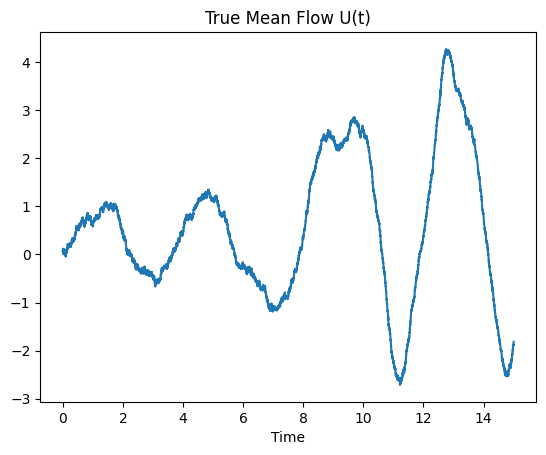

In [45]:
from scipy.io import loadmat

data = loadmat("/Users/lydiatolman/Desktop/Research/DA/code_baro_condGau/baro_init_K10sk20sU10dk1dU15.mat")

# See what's inside
print(data.keys())

U_true = data['Uout'].squeeze()         # mean flow (observed variable)
v_hat_true = data['vout'].squeeze()           # complex or real hidden modes
T_hat_true = data['Tout'].squeeze()           # temperature modes (if present)
t_true = data['TT'].squeeze()         # time array
print(t_true.shape)
print(T_hat_true.shape)
print(v_hat_true.shape)
print(U_true.shape)
# t_vals = data['t'].squeeze()         # time array
# t_true = np.linspace(0, 1, len(U_true))
v_hat_true = np.array(v_hat_true, dtype=np.complex128)
print("U shape:", U_true.shape)
print("v_hat shape:", v_hat_true.shape)
print("Time range:", t_true[0], "→", t_true[-1])
print("T_hat shape:", T_hat_true.shape)
plt.figure()
plt.plot(t_true, U_true)
plt.title("True Mean Flow U(t)")
plt.xlabel("Time")
plt.show()


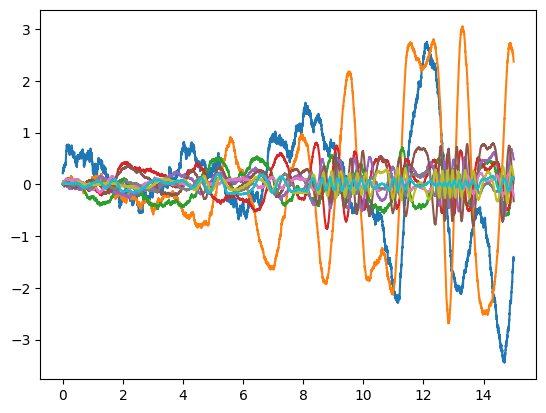

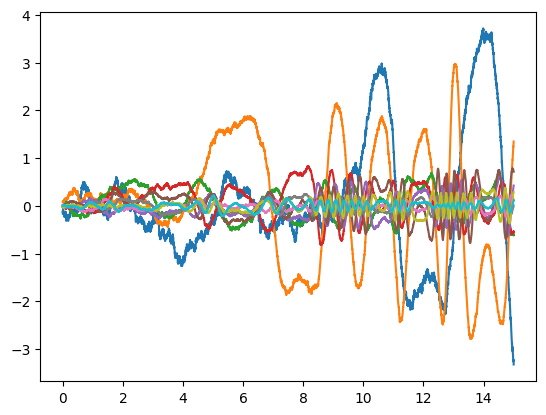

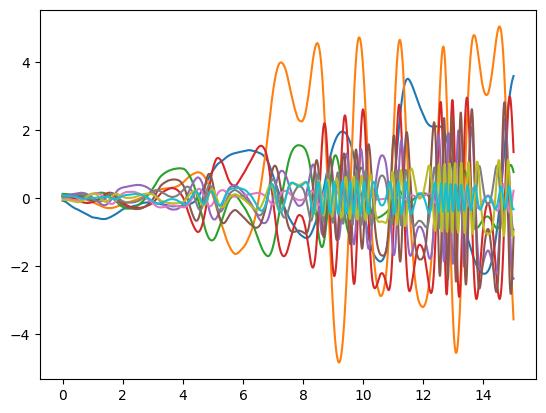

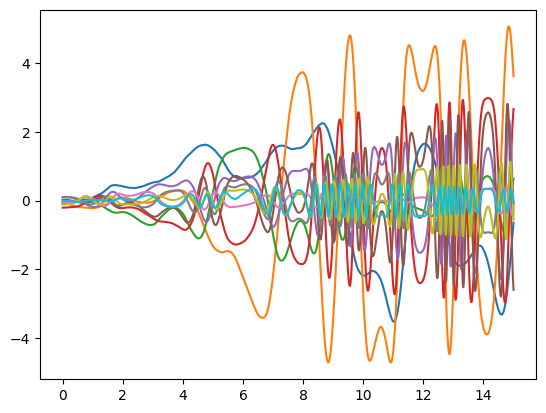

In [46]:
for i in range(10):
    plt.plot(t_true, np.real(v_hat_true[i,:]), label=f"Mode {i+1}")
plt.show()
for i in range(10):
    plt.plot(t_true, np.imag(v_hat_true[i,:]), label=f"Mode {i+1}")
plt.show()
for i in range(10):
    plt.plot(t_true, np.real(T_hat_true[i,:]), label=f"Mode {i+1}")
plt.show()
for i in range(10):
    plt.plot(t_true, np.imag(T_hat_true[i,:]), label=f"Mode {i+1}")

In [57]:
params = dict(
    beta=1.0,
    hk=np.array([
        0.5 - 0.5j,
        0.25 - 0.25j,
        0.05555556 - 0.05555556j,
        0.03125 - 0.03125j,
        0.02 - 0.02j,
        0.01388889 - 0.01388889j,
        0.01020408 - 0.01020408j,
        0.0078125 - 0.0078125j,
        0.00617284 - 0.00617284j,
        0.005 - 0.005j
    ]),
    kmax=np.array([[10]]),
    kvec=np.arange(1, 11).reshape(-1, 1),
    d_k=np.ones((10, 1)) * 0.0125,
    d_U=0.0125,
    sig_k=np.array([
        0.70710678,
        0.35355339,
        0.23570226,
        0.1767767,
        0.14142136,
        0.11785113,
        0.10101525,
        0.08838835,
        0.07856742,
        0.07071068
    ]),
    sig_U=np.array([[0.35355339]]),
    gamma_T=np.array([
        0.101, 0.104, 0.109, 0.116, 0.125,
        0.136, 0.149, 0.164, 0.181, 0.2
    ]),
    f_k=np.zeros((10, 1)),
    f_U=np.zeros((1, 1)),
    alpha=1,
)



def f_uI(t, uI, uII, params):
    """
    Equation (1a): mean flow U.
    """
    hk = np.asarray(params["hk"]).flatten()
    d_U = params["d_U"]
    sigma0 = params.get("sigma0", 0.0)  # stochastic term ignored (0) for deterministic filter

    n = hk.size
    v_real = uII[:n]  # complex array
    v_imag = uII[n:2*n]
    v_hat = v_real + 1j * v_imag  # complex array

    term1 = np.sum(np.conjugate(hk) * v_hat)
    dUdt = np.real(term1) - d_U * float(np.real(uI))
    return np.array([dUdt])



def f_uII(t, uI, uII, params):

    hk = np.asarray(params["hk"]).flatten()
    kvec = np.asarray(params["kvec"]).flatten().astype(float)
    lx = float(params.get("lx", 1.0))
    alpha = float(params["alpha"])
    d_v = params.get("d_v", np.zeros_like(hk))
    d_T = params.get("d_T", np.zeros_like(hk))
    sig_k = params["sig_k"]  
    beta = float(params["beta"])

    gamma_T = np.array(params["gamma_T"]).astype(np.float64).flatten()
    

    n = hk.size
    v_real = uII[:n]
    v_imag = uII[n:2*n]
    T_real = uII[2*n:3*n]
    T_imag = uII[3*n:4*n]
    v_hat = v_real + 1j * v_imag
    T_hat = T_real + 1j * T_imag
    U = np.real(uI)

    # gamma_v = np.zeros(n, dtype=np.float64) + .001 +  (.0002 * kvec) ** 2 
    gamma_v = np.zeros(n, dtype=np.float64) 
    omega_v = lx * (beta / kvec - kvec * U)
    omega_T = -kvec * U
    # dvdt = ((-gamma_v - d_v) + 1j * omega_v) * v_hat - (lx ** 2) * hk * uI
    dvdt = (-gamma_v - d_v) * v_hat + 1j * (omega_v * v_hat) - (lx ** 2) * hk * U


    dTdt = (-gamma_T - d_T) * T_hat + 1j * (omega_T * T_hat) - alpha * v_hat
    # print("dvdt:", dvdt.shape, "dTdt:", dTdt.shape)
    return np.concatenate([np.real(dvdt).flatten(), np.imag(dvdt).flatten(), np.real(dTdt), np.imag(dTdt)])


# Example run
t_span = (0, 15)
# n_steps = 501
# dt = (t_span[1] - t_span[0]) / n_steps
# U_obs = U_true + 0.05 * np.random.randn(len(U_true))

# t_vals = np.linspace(*t_span, n_steps)
# U_obs = np.sin(0.2 * t_vals)  # mock observed mean flow
v0_complex = v_hat_true[:,0]
T0_complex = T_hat_true[:,0]
print(v0_complex.shape)
# v0_complex = v_hat_true[:, 1, 0]
# T0_complex = T_hat_true[:, 1, 0]

# uII_0 = np.random.randn(20) + 1j * np.random.randn(20)  # 10 v_k + 10 T_k
uII_v = np.concatenate([np.real(v0_complex), np.imag(v0_complex)])
uII_T = np.concatenate([np.real(T0_complex), np.imag(T0_complex)])
uII_0 = (np.concatenate([uII_v, uII_T]) + .1* np.random.randn(40))*1.0  # initial hidden state

kvec = params['kvec'].flatten()
# sigma_v0 = 10.0 / (1.0 + kvec**2)                
# var_v = (sigma_v0 / params['sig_k'].flatten())**2
# var_T = .0005*(params['sig_k'].flatten())**2 + (1.0 + kvec**2)**2  # tracer noise smaller
# Sigma2 = .1*np.diag(np.concatenate([var_v, var_v, var_T, var_T]))
# sig_v = params['sig_k'].flatten() / (params['kvec'].flatten())
scale = 0.3
sig_v = (params['sig_k'].flatten()*scale)**2
Sigma2 = 20*np.diag(np.concatenate([sig_v, 1*sig_v, .05*sig_v, .05*sig_v]))
# Run filter (real and imaginary parts flattened for real-valued filter)
# uII_0_real = np.concatenate([np.real(uII_0), np.imag(uII_0)])
# offset = np.ones(40)
# offset[::4] = 0.1
# diag = np.concatenate((np.arange(10),np.arange(10)*.01,np.arange(10),np.arange(10)*.01))
# Sigma2 = np.diag(.01*diag)
# Sigma2 = (np.eye(40) * 0.5) * np.diag(offset)  # process noise covariance for hidden states

SigmaI = np.eye(1)*.05 # observation noise covariance for observed state
R0 = np.eye(40)*.01 # initial error covariance  
results = kalman_bucy(
    lambda t, U, uII: f_uI(t, U, uII, params),
    lambda t, U, uII: f_uII(t, U, uII, params),
    t_span=t_span,
    uI=U_true,
    uII_0=uII_0,
    SigmaI=SigmaI,
    SigmaII=Sigma2,
    R0=R0
)





(10,)
(40,) (40, 40)


RK4 Kalman–Bucy:   0%|          | 0/15000 [00:00<?, ?it/s]/var/folders/tf/2nv3zwtj1mbc0w0r383g3tjw0000gn/T/ipykernel_96356/1614242802.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dUdt = np.real(term1) - d_U * float(np.real(uI))
RK4 Kalman–Bucy: 100%|██████████| 15000/15000 [00:49<00:00, 301.47it/s]


In [48]:
results["uII"].shape
vk_real = results["uII"][:10,:] 

vk_imag = 1j * results["uII"][10:20,:]
Tk_real = results["uII"][20:30,:] 
Tk_imag = 1j * results["uII"][30:40,:]

In [49]:
results["t"]

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 1.4998e+01, 1.4999e+01,
       1.5000e+01], shape=(15001,))

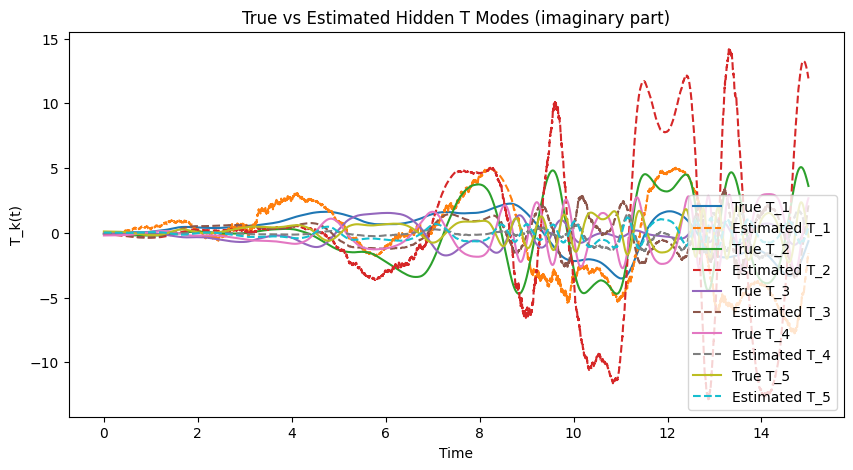

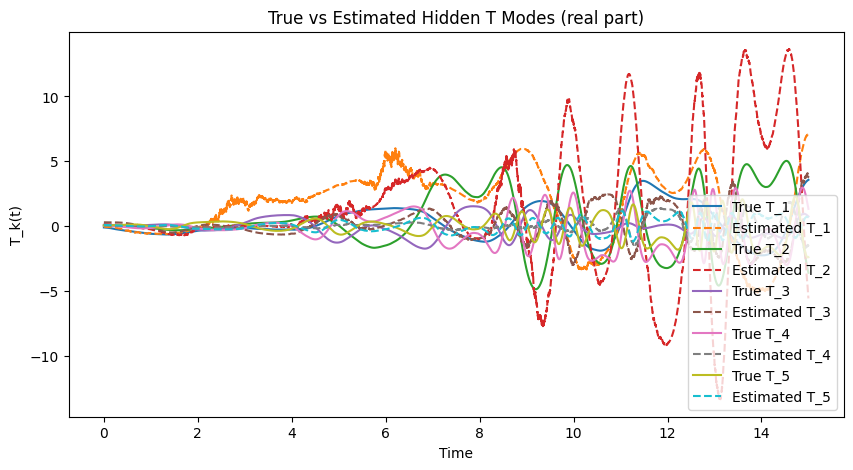

In [50]:
n_modes = 5

plt.figure(figsize=(10,5))
for i in range(n_modes):
    plt.plot(t_true, np.imag(T_hat_true[i,:]), label=f"True T_{i+1}")
    plt.plot(results["t"], np.imag(Tk_imag[i]), "--", label=f"Estimated T_{i+1}")
plt.title("True vs Estimated Hidden T Modes (imaginary part)")
plt.xlabel("Time")
plt.ylabel("T_k(t)")
# plt.xlim(0, 5)
# plt.ylim(0,100000)
plt.legend(loc = 'lower right')
plt.show()

plt.figure(figsize=(10,5))
for i in range(n_modes):
    plt.plot(t_true, np.real(T_hat_true[i,:]), label=f"True T_{i+1}")
    plt.plot(results["t"], np.real(Tk_real[i]), "--", label=f"Estimated T_{i+1}")
plt.title("True vs Estimated Hidden T Modes (real part)")
plt.xlabel("Time")
plt.ylabel("T_k(t)")
# plt.xlim(0, 5)
# plt.ylim(0,100000)
plt.legend(loc = 'lower right')
plt.show()


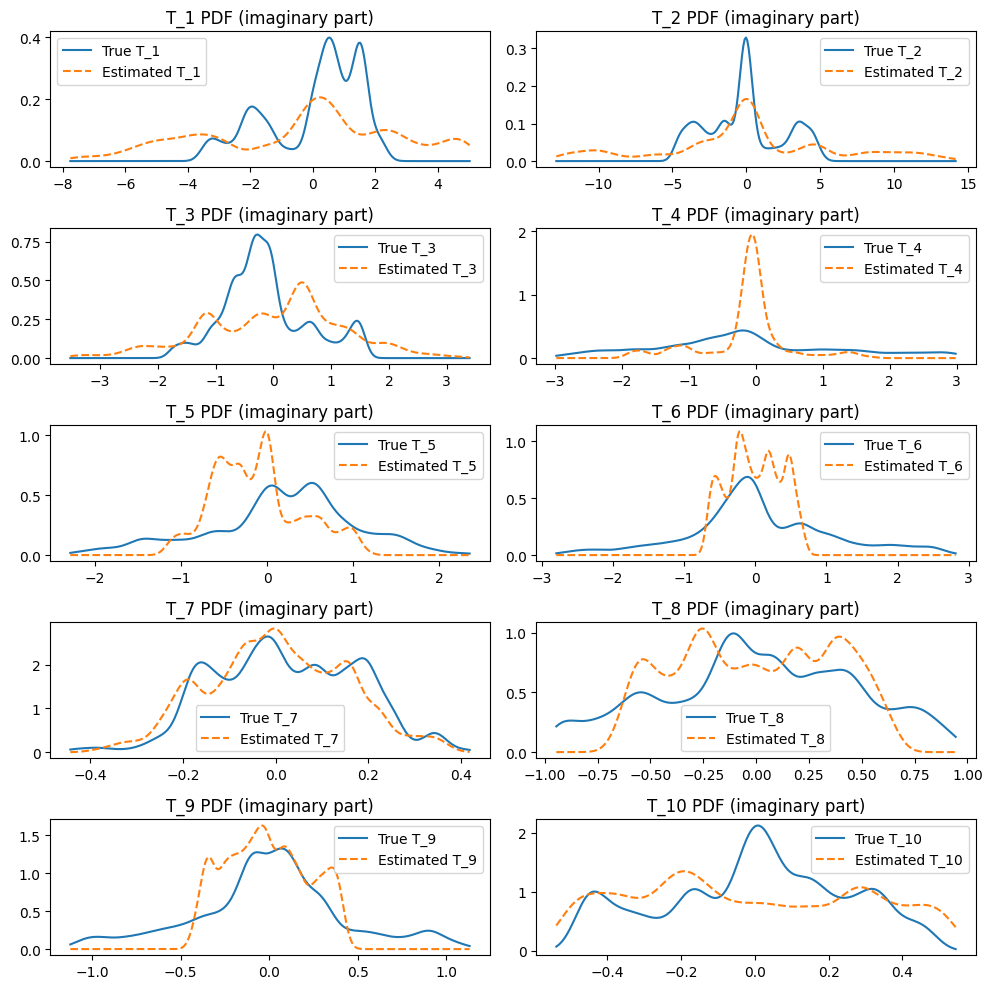

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 10))
n_modes = 10
for i in range(n_modes):
    plt.subplot(n_modes//2, 2, i + 1)
    true_data = np.imag(T_hat_true[i, :])
    est_data = np.imag(Tk_imag[i])
    
    # Estimate smooth PDFs using Gaussian KDE
    kde_true = gaussian_kde(true_data)
    kde_est = gaussian_kde(est_data)
    
    # Define a common range for both distributions
    x_min = min(true_data.min(), est_data.min())
    x_max = max(true_data.max(), est_data.max())
    x_vals = np.linspace(x_min, x_max, 300)
    
    # Plot PDFs
    plt.plot(x_vals, kde_true(x_vals), label=f"True T_{i+1}")
    plt.plot(x_vals, kde_est(x_vals), '--', label=f"Estimated T_{i+1}")
    plt.legend()
    plt.title(f"T_{i+1} PDF (imaginary part)")
plt.tight_layout()
plt.show()

# plt.title("Probability Density Function of True vs Estimated Temperature Modes")
# plt.xlabel("T_k (real part)")
# plt.ylabel("Probability Density")
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


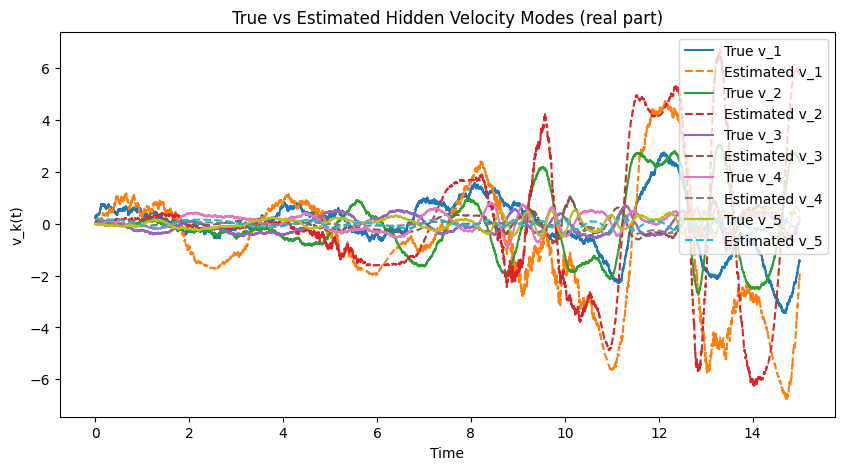

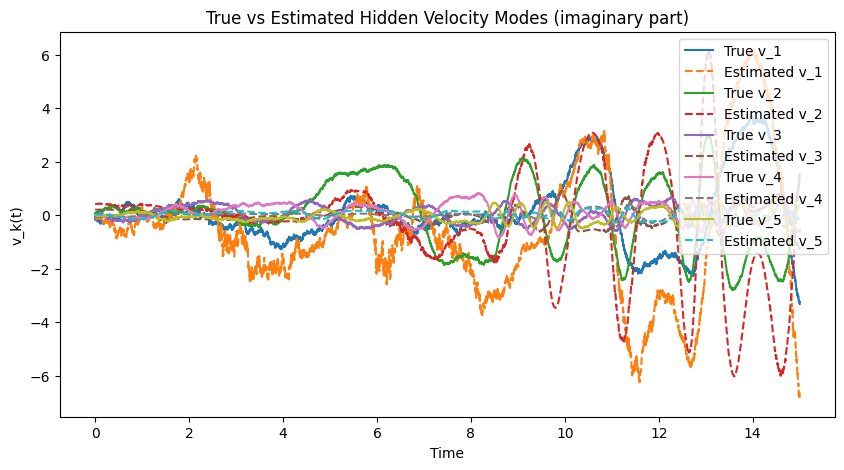

In [52]:
n_modes = 5
plt.figure(figsize=(10,5))
for i in range(n_modes):
    plt.plot(t_true, np.real(v_hat_true[i,:]), label=f"True v_{i+1}")
    plt.plot(results["t"], np.real(vk_real[i]), "--", label=f"Estimated v_{i+1}")
plt.title("True vs Estimated Hidden Velocity Modes (real part)")
plt.xlabel("Time")
plt.ylabel("v_k(t)")
# plt.xlim(0, 5)
# plt.ylim(0,100000)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for i in range(n_modes):
    plt.plot(t_true, np.imag(v_hat_true[i,:]), label=f"True v_{i+1}")
    plt.plot(results["t"], np.imag(vk_imag[i]), "--", label=f"Estimated v_{i+1}")
plt.title("True vs Estimated Hidden Velocity Modes (imaginary part)")
plt.xlabel("Time")
plt.ylabel("v_k(t)")
# plt.xlim(0, 5)
# plt.ylim(0,100000)
plt.legend()
plt.show()


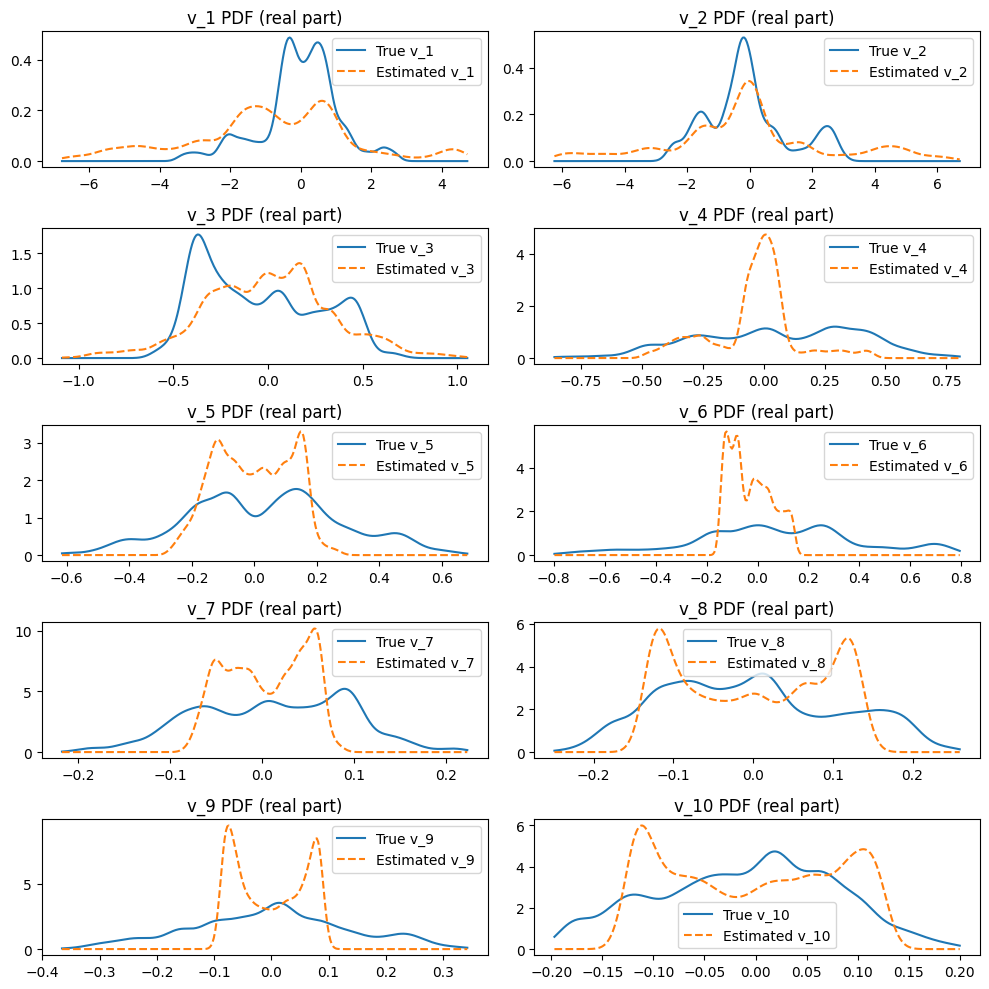

In [53]:
plt.figure(figsize=(10, 10))

n_modes = 10
for i in range(n_modes):
    plt.subplot(n_modes//2, 2, i + 1)
    true_data = np.real(v_hat_true[i, :])
    est_data = np.real(vk_real[i])
    
    # Estimate smooth PDFs using Gaussian KDE
    kde_true = gaussian_kde(true_data)
    kde_est = gaussian_kde(est_data)
    
    # Define a common range for both distributions
    x_min = min(true_data.min(), est_data.min())
    x_max = max(true_data.max(), est_data.max())
    x_vals = np.linspace(x_min, x_max, 300)
    
    # Plot PDFs
    plt.plot(x_vals, kde_true(x_vals), label=f"True v_{i+1}")
    plt.plot(x_vals, kde_est(x_vals), '--', label=f"Estimated v_{i+1}")
    plt.legend()
    plt.title(f"v_{i+1} PDF (real part)")
plt.tight_layout()
plt.show()

# plt.title("Probability Density Function of True vs Estimated Temperature Modes")
# plt.xlabel("T_k (real part)")
# plt.ylabel("Probability Density")
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


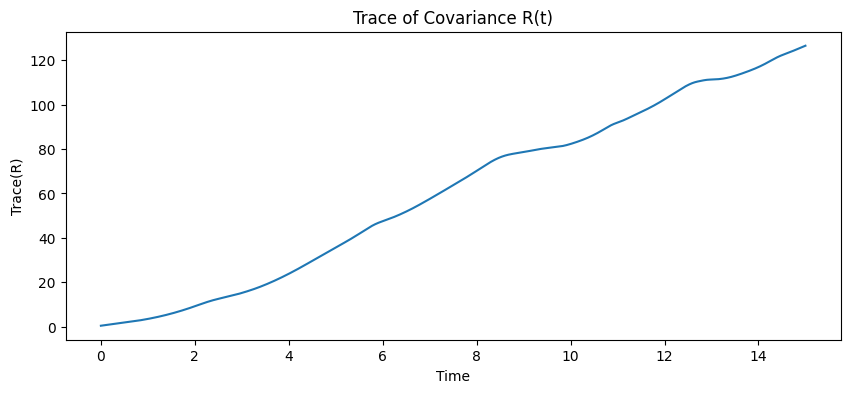

In [54]:
# Plot covariance trace
plt.figure(figsize=(10,4))
trace_R = np.trace(results["R"], axis1=1, axis2=2)
plt.plot(results["t"], trace_R)
plt.title("Trace of Covariance R(t)")
plt.xlabel("Time")
plt.ylabel("Trace(R)")
plt.show()



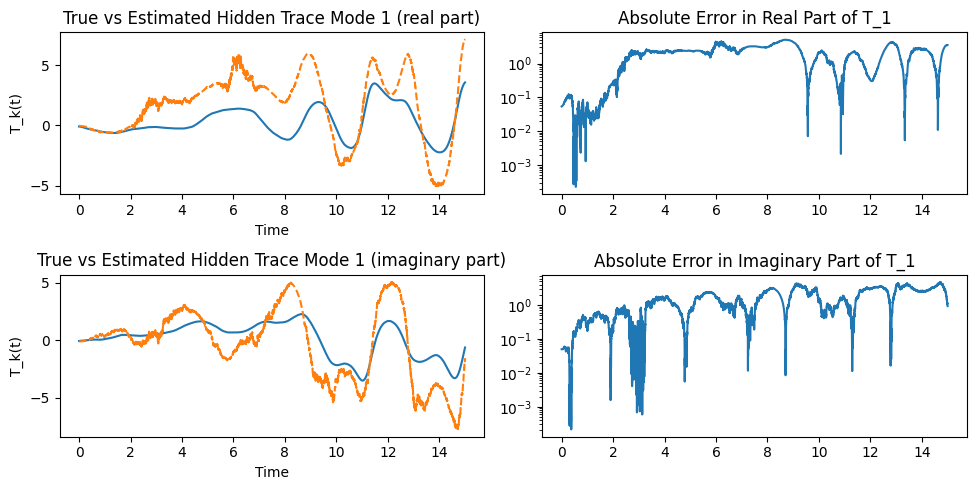

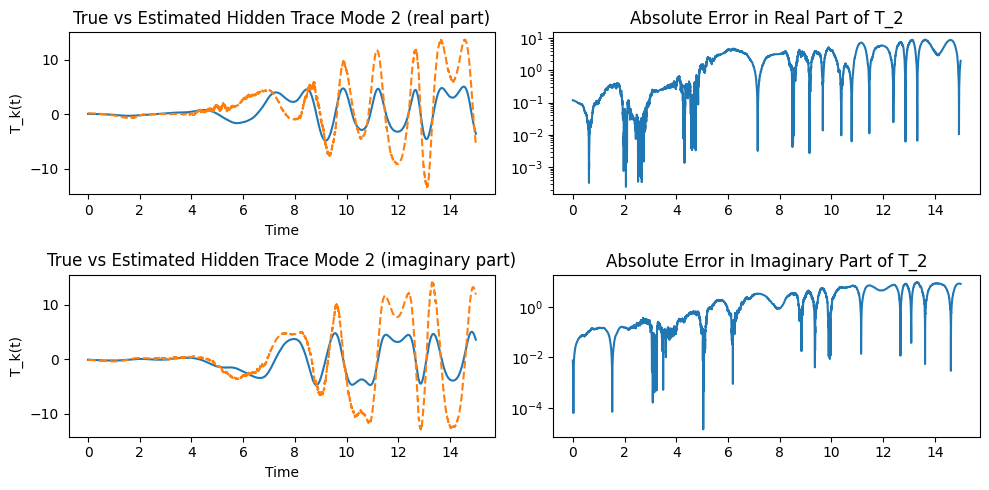

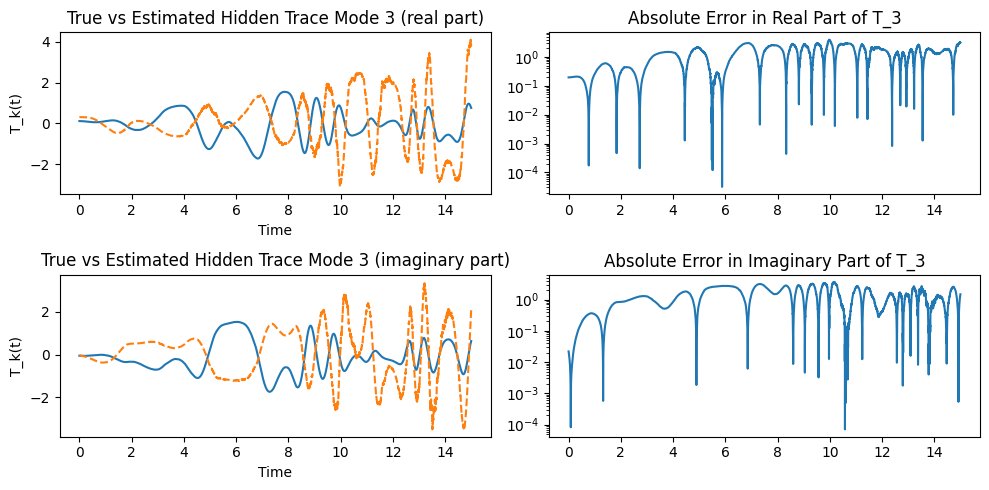

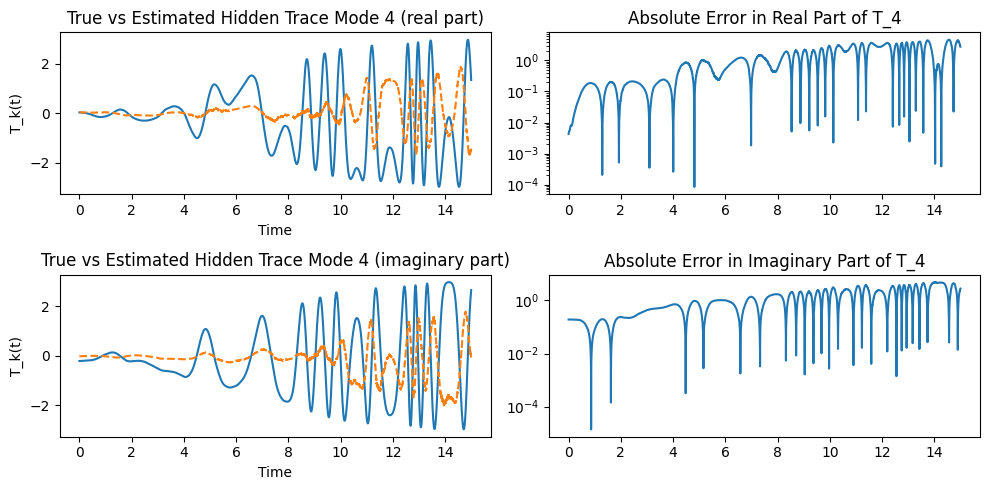

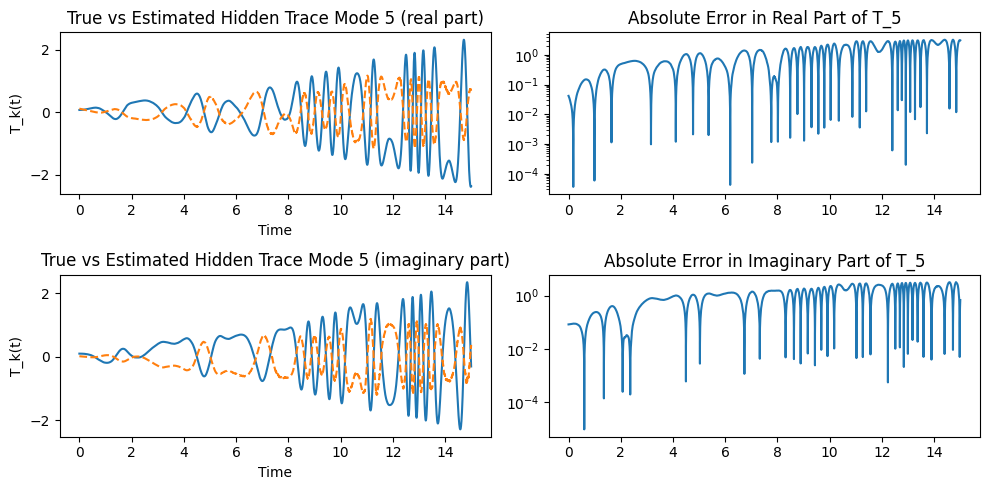

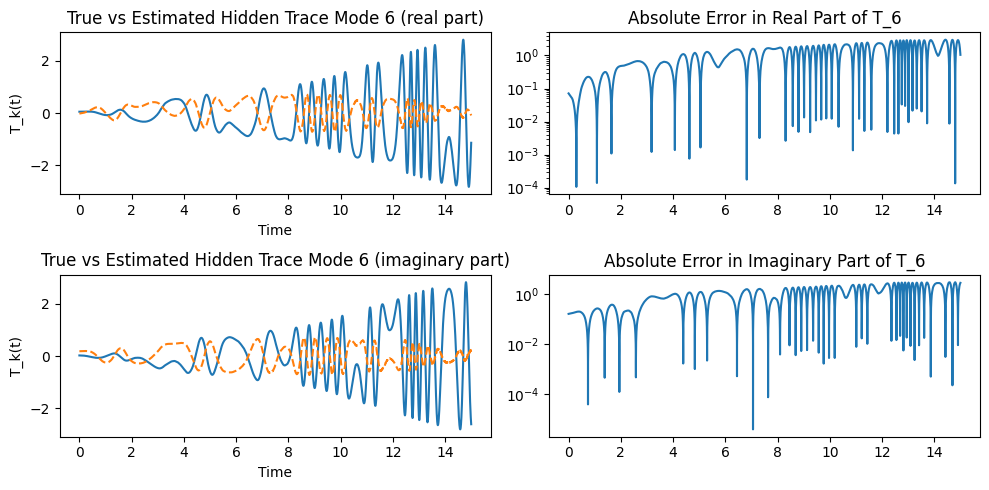

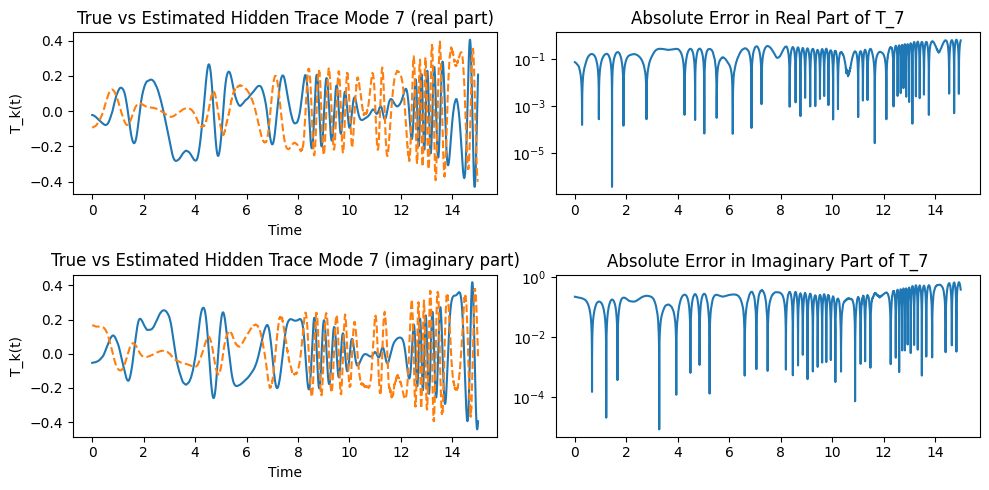

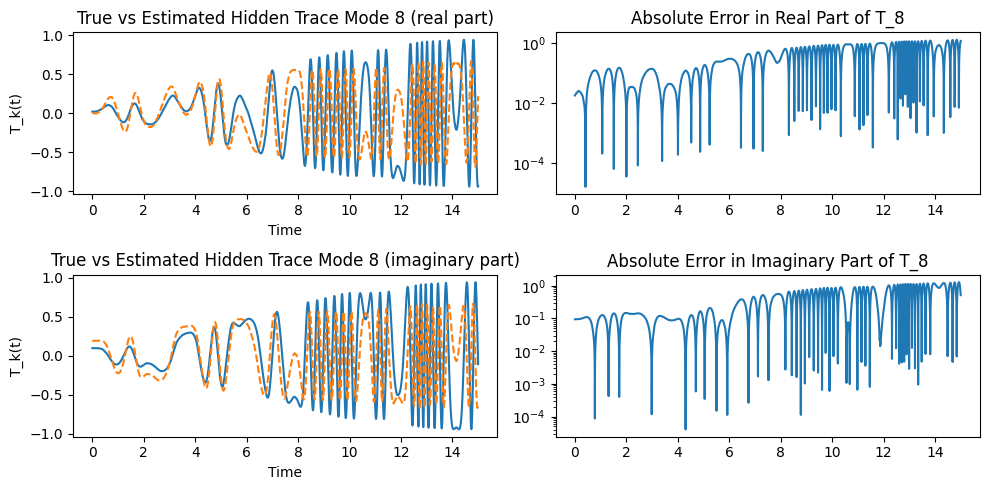

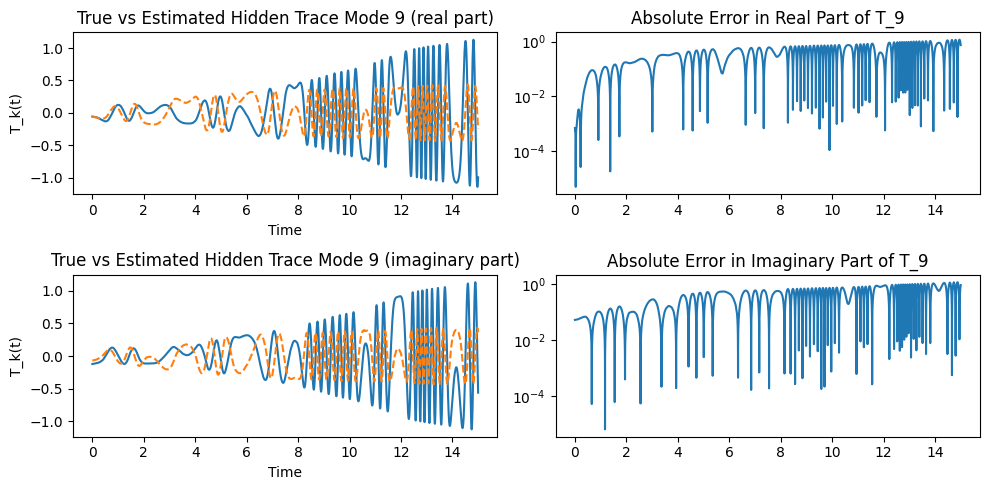

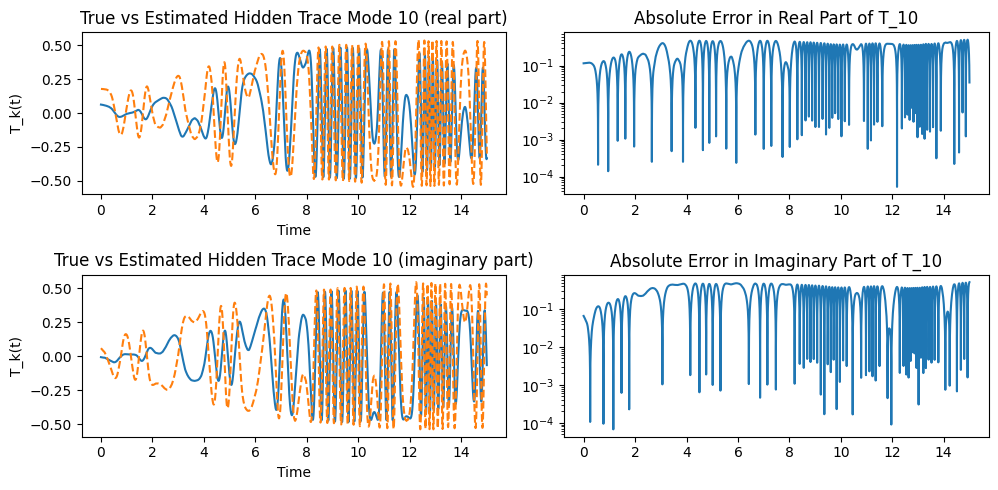

/var/folders/tf/2nv3zwtj1mbc0w0r383g3tjw0000gn/T/ipykernel_96356/2951061599.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper left')


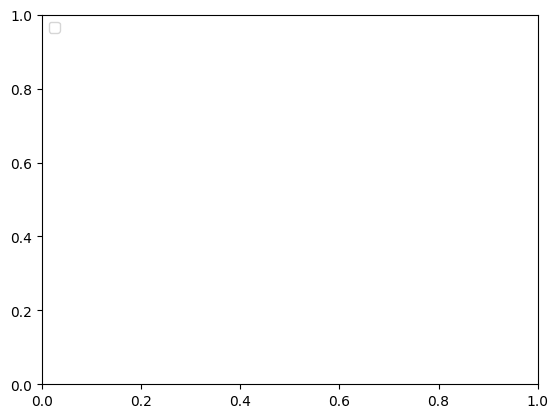

In [55]:
n_modes = 10

# plt.figure(figsize=(10,5))
# for i in range(n_modes):
#     plt.plot(t_true, np.imag(T_hat_true[i,:]), label=f"True T_{i+1}")
#     plt.plot(results["t"], np.imag(Tk_imag[i]), "--", label=f"Estimated T_{i+1}")
#     plt.title(f"True vs Estimated Hidden Trace Mode {i+1} (imaginary part)")
#     plt.xlabel("Time")
#     plt.ylabel("T_k(t)")
#     plt.show()
# # plt.xlim(0, 5)
# # plt.ylim(0,100000)
# plt.legend(loc = 'upper left')
# plt.show()

for i in range(n_modes):
    plt.figure(figsize=(10,5))
    plt.subplot(221)
    plt.plot(t_true, np.real(T_hat_true[i,:]), label=f"True T_{i+1}")
    plt.plot(results["t"], np.real(Tk_real[i]), "--", label=f"Estimated T_{i+1}")
    plt.title(f"True vs Estimated Hidden Trace Mode {i+1} (real part)")
    plt.xlabel("Time")
    plt.ylabel("T_k(t)")
    plt.subplot(222)
    plt.semilogy(t_true, abs(np.real(T_hat_true[i,:]) - np.real(Tk_real[i])), label=f"Absolute Error T_{i+1}")
    plt.title(f"Absolute Error in Real Part of T_{i+1}")
    plt.subplot(223)
    plt.plot(t_true, np.imag(T_hat_true[i,:]), label=f"True T_{i+1}")
    plt.plot(results["t"], np.imag(Tk_imag[i]), "--", label=f"Estimated T_{i+1}")
    plt.title(f"True vs Estimated Hidden Trace Mode {i+1} (imaginary part)")
    plt.xlabel("Time")
    plt.ylabel("T_k(t)")
    plt.subplot(224)
    plt.semilogy(t_true, abs(np.imag(T_hat_true[i,:]) - np.imag(Tk_imag[i])), label=f"Absolute Error T_{i+1}")
    plt.title(f"Absolute Error in Imaginary Part of T_{i+1}")
    plt.tight_layout()
    plt.show()
# plt.xlim(0, 5)
# plt.ylim(0,100000)
plt.legend(loc = 'upper left')
plt.show()


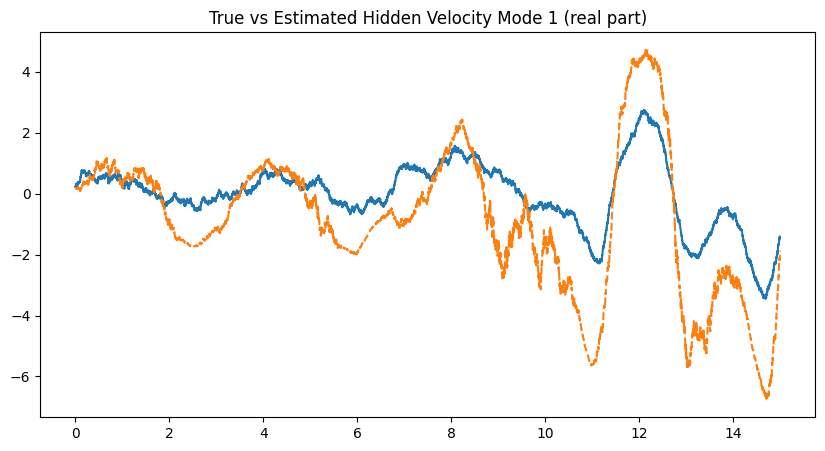

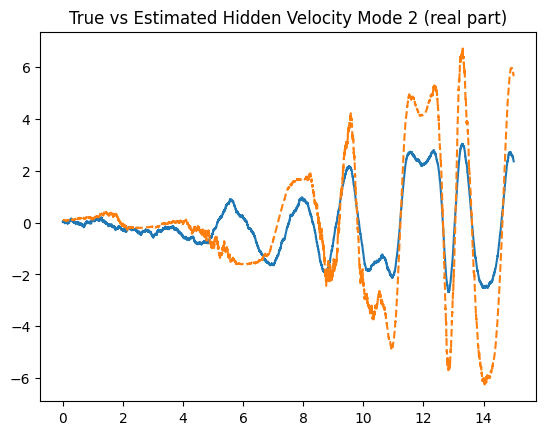

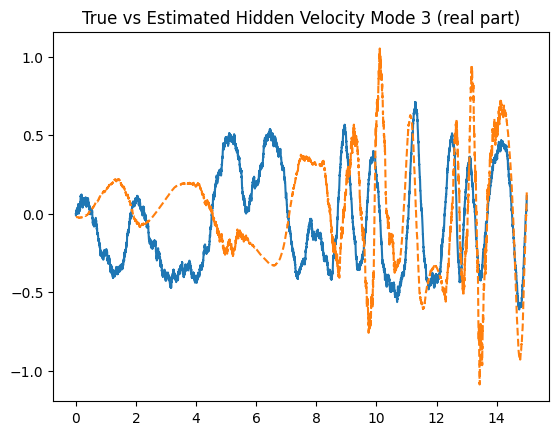

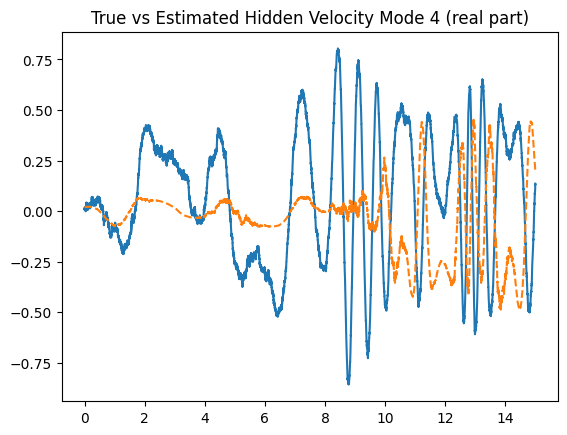

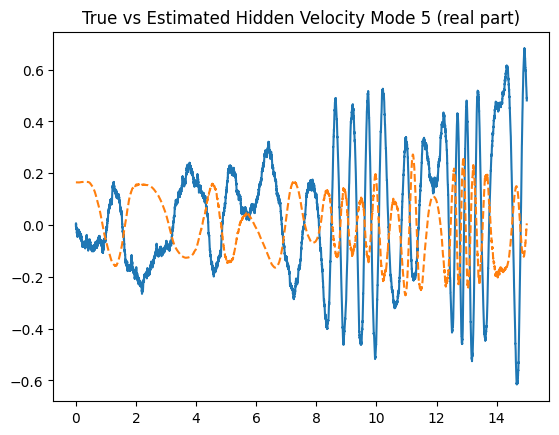

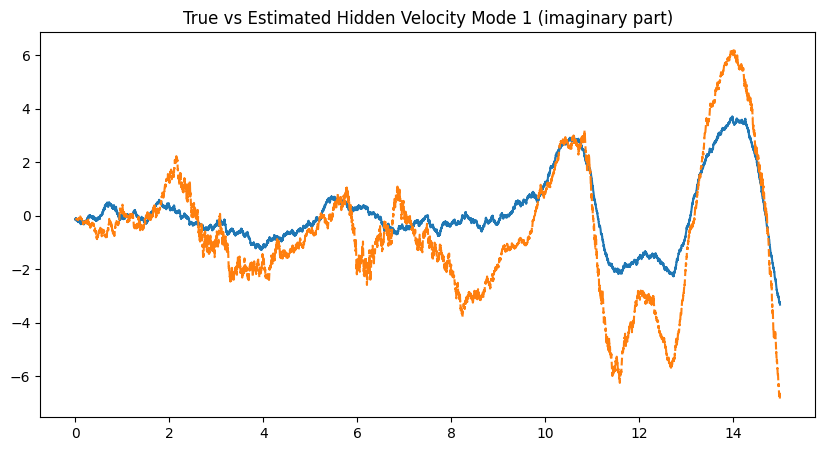

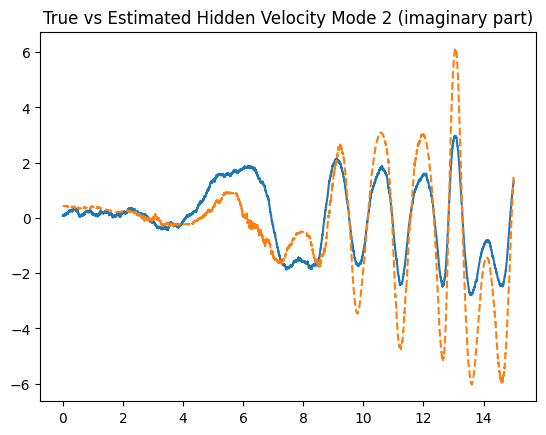

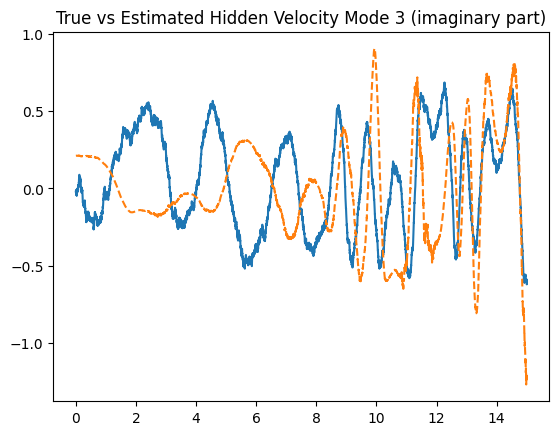

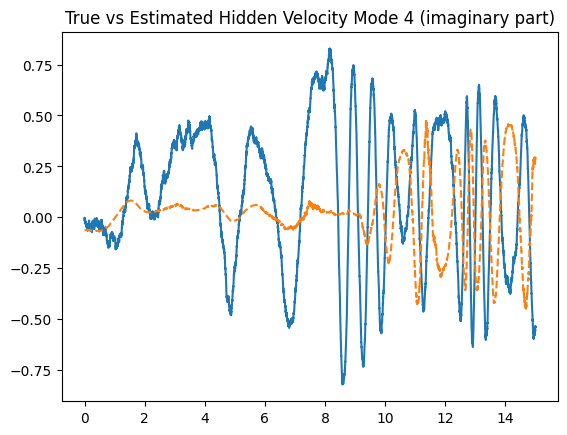

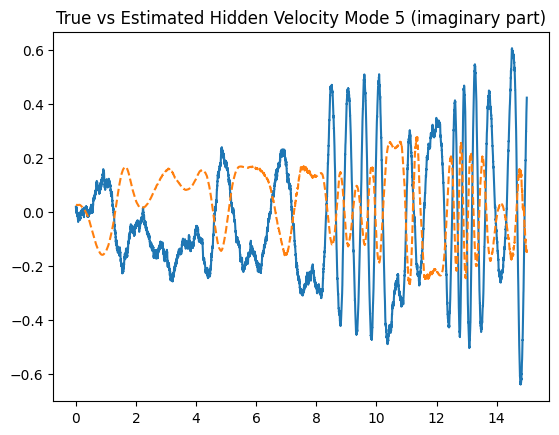

In [56]:
n_modes = 5
plt.figure(figsize=(10,5))
for i in range(n_modes):
    plt.plot(t_true, np.real(v_hat_true[i,:]), label=f"True v_{i+1}")
    plt.plot(results["t"], np.real(vk_real[i]), "--", label=f"Estimated v_{i+1}")
    plt.title(f"True vs Estimated Hidden Velocity Mode {i+1} (real part)")
    plt.show()
#
# plt.title("True vs Estimated Hidden Velocity Modes (real part)")
# plt.xlabel("Time")
# plt.ylabel("v_k(t)")
# plt.xlim(0, 5)
# # plt.ylim(0,100000)
# plt.legend()
# plt.show()

plt.figure(figsize=(10,5))
for i in range(n_modes):
    plt.plot(t_true, np.imag(v_hat_true[i,:]), label=f"True v_{i+1}")
    plt.plot(results["t"], np.imag(vk_imag[i]), "--", label=f"Estimated v_{i+1}")
    plt.title(f"True vs Estimated Hidden Velocity Mode {i+1} (imaginary part)")
    plt.show()
# plt.ylim(0,100000)
# plt.legend()
# plt.show()
